选股:   
allist = ['601099.XSHG','002415.XSHE','601901.XSHG','601633.XSHG','601628.XSHG','300760.XSHE','600362.XSHG','300003.XSHE','300244.XSHE','600973.XSHG',\
                '000429.XSHE','603027.XSHG','600588.XSHG','600373.XSHG','688008.XSHG','000066.XSHE','600260.XSHG','300357.XSHE','000977.XSHE','600845.XSHG',\
                '300383.XSHE','002008.XSHE','600487.XSHG','300558.XSHE','002396.XSHE','600498.XSHG','300750.XSHE','002466.XSHE','002460.XSHE','600255.XSHG']
1.去除,退市,停牌,涨停   
2.计算每只股票的DIF，DEA，MACD    
3.如果-0.009>MACD[-1]>MACD[-2]>MACD[-3] and DIF[-1]<DEA[-1]<1    
4.如果当前macd这个值大于小于零轴的所有macd的均值且快线连续两个增长 MACD[-1]>np.mean(macdminus) and DIF[-1]>DIF[-2]  

In [ ]:
买入：14：40  
最大持仓：30只
出现上述信号才买入
卖出：高点跌5%
止损：成本价10%
回测日期：2018-01-01  2020-11-28
起始资金: 1千五百万
回测频率: 分钟

In [ ]:
回测代码：20201130_02

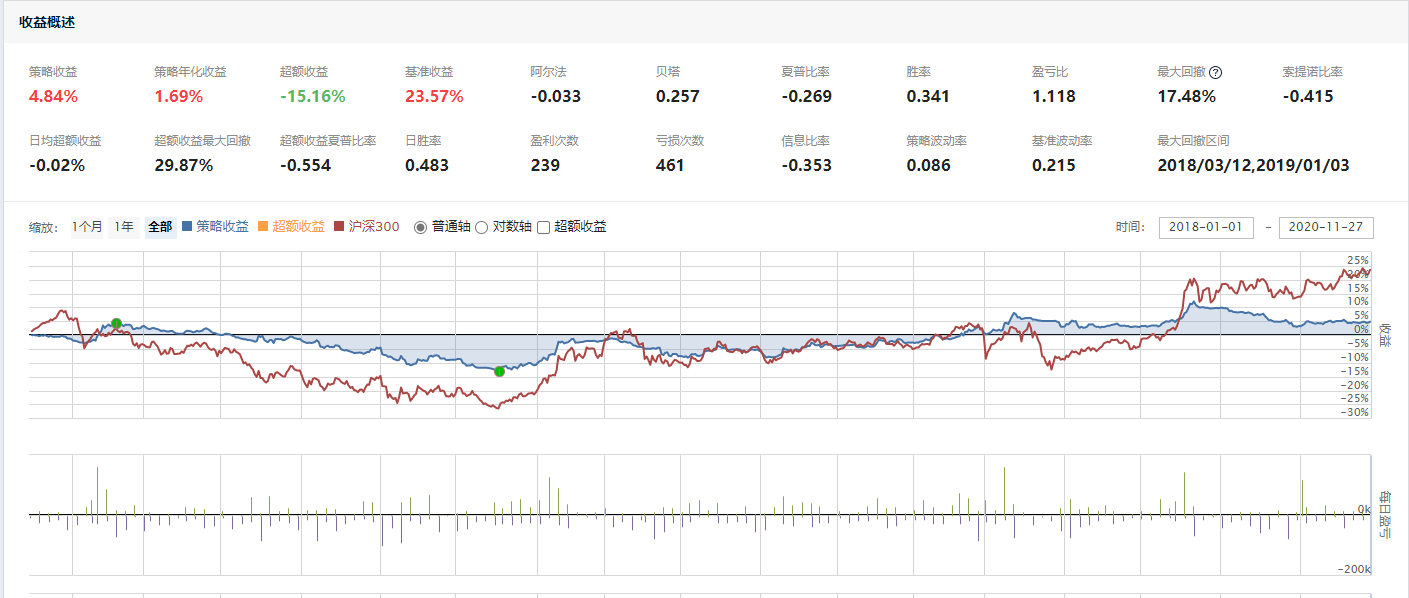

In [ ]:
代码：

In [ ]:
# 导入函数库
from jqdata import *
import talib
import numpy as np
import random

# 初始化函数，设定基准等等
def initialize(context):
    # 设定沪深300作为基准
    set_benchmark('000300.XSHG')
    # 开启动态复权模式(真实价格)
    set_option('use_real_price', True)
    # 输出内容到日志 log.info()
    log.info('初始函数开始运行且全局只运行一次')
    # 过滤掉order系列API产生的比error级别低的log
    # log.set_level('order', 'error')
    g.cash = context.portfolio.available_cash
    g.max_num = 30
    g.div_cash = g.cash/g.max_num
    # 记录最高的收盘价
    g.single_max={}
    # 记录买入价
    g.single_cost={}
    # 止损率
    g.stoploss_rate = 0.1
    # 高点止盈
    g.stopwin_rate = 0.05
    ### 股票相关设定 ###
    # 股票类每笔交易时的手续费是：买入时佣金万分之三，卖出时佣金万分之三加千分之一印花税, 每笔交易佣金最低扣5块钱
    set_order_cost(OrderCost(close_tax=0.001, open_commission=0.0003, close_commission=0.0003, min_commission=5), type='stock')

    ## 运行函数（reference_security为运行时间的参考标的；传入的标的只做种类区分，因此传入'000300.XSHG'或'510300.XSHG'是一样的）
      # 开盘前运行
    run_daily(before_market_open, time='before_open', reference_security='000300.XSHG')
    run_daily(sell, time='every_bar', reference_security='000300.XSHG')
    run_daily(stop_loss, time='every_bar', reference_security='000300.XSHG')
    run_daily(buy, time='14:40', reference_security='000300.XSHG')
      # 收盘后运行
    run_daily(after_market_close, time='after_close', reference_security='000300.XSHG')

## 开盘前运行函数
def before_market_open(context):
    # 输出运行时间
    log.info('函数运行时间(before_market_open)：'+str(context.current_dt.time()))
    
    # allist = get_index_stocks('000906.XSHG', date=context.current_dt.date())
    allist = ['601099.XSHG','002415.XSHE','601901.XSHG','601633.XSHG','601628.XSHG','300760.XSHE','600362.XSHG','300003.XSHE','300244.XSHE','600973.XSHG',\
                '000429.XSHE','603027.XSHG','600588.XSHG','600373.XSHG','688008.XSHG','000066.XSHE','600260.XSHG','300357.XSHE','000977.XSHE','600845.XSHG',\
                '300383.XSHE','002008.XSHE','600487.XSHG','300558.XSHE','002396.XSHE','600498.XSHG','300750.XSHE','002466.XSHE','002460.XSHE','600255.XSHG']
    print(len(allist))
    allist = filter_paused_stock(allist)
    #allist = filter_st_stock(allist)
    allist = filter_limitup_stock(allist)
    print(len(allist))
    f1list = []
    for i in allist:
        #prices = attribute_history(i,300, '1w',['close'])       #取较长周期的数据，这里为300日
        prices = get_bars(i, 200, unit='1d',fields=['date','close'],
         include_now=False, end_dt=None, df=False)
        #print(prices)
        price = array(prices['close'])                              #将price一列函数格式变为array
        # print(price)
        macd_tmp = talib.MACD(price, fastperiod=12, slowperiod=26, signalperiod=9)   #将参数传入MACD函数中
        DIF = macd_tmp[0]                                           #返回的数据分别为短期慢线DIF、长期快线DEA及MACD
        DEA = macd_tmp[1]
        MACD = macd_tmp[2]
        # print(DIF,DEA,MACD)
        if -0.009>MACD[-1]>MACD[-2]>MACD[-3] and DIF[-1]<DEA[-1]<1:
            
            index = [list(MACD).index(x) for x in list(MACD) if (x>0 or x==np.nan)]
            print(i,list(MACD),index)
            if index:
                macdminus = list(MACD)[index[-1]+1:]
                # print(macdminus)
                if MACD[-1]>np.mean(macdminus) and DIF[-1]>DIF[-2]:
                    f1list.append(i)
    print(f1list)
    # if len(f1list)<=10:
    #     g.f1_buy = f1list
    # else:
    if f1list:
        g.need_buy = f1list 
    
## 开盘时运行函数
def buy(context):
    log.info('函数运行时间(buy):'+str(context.current_dt.time()))
    positions = context.portfolio.positions.keys()
    # 取得当前的现金
    cash = context.portfolio.available_cash
    for i in g.need_buy:
        # 如果不存在才买
        if cash > 0 and i not in positions:
            # 记录这次买入
            log.info("买入 %s" % (i))
            # 用所有 cash 买入股票
            order_value(i, g.div_cash)
            
def sell(context):
    positions = context.portfolio.positions.keys()
    # 判断持仓
    if positions:
        for pos in positions:
            current_data = get_current_data() 
            if pos in g.single_max.keys() and current_data[pos].last_price < g.single_max[pos]*(1-g.stopwin_rate):
                print(current_data[pos].last_price,g.single_max[pos]*(1-g.stopwin_rate))
                log.info('函数运行时间(sell):'+str(context.current_dt.time()))
                order_target_value(pos,0)
                del g.single_max[pos]
                del g.single_cost[pos]
def stop_loss(context):
    positions = context.portfolio.positions.keys()
    # 判断持仓
    if positions:
        for pos in positions:
            current_data = get_current_data() 
            if pos in g.single_cost.keys() and current_data[pos].last_price < g.single_cost[pos]*(1-g.stoploss_rate):
                # print(current_data[pos].last_price,g.single_max[pos]*0.85)
                log.info('函数运行时间(stop_loss):'+str(context.current_dt.time()))
                order_target_value(pos,0)
                del g.single_max[pos]
                del g.single_cost[pos]    

## 收盘后运行函数
def after_market_close(context):
    log.info(str('函数运行时间(after_market_close):'+str(context.current_dt.time())))
    long_positions_dict = context.portfolio.long_positions
    print(long_positions_dict)
    for position in list(long_positions_dict.values()):  
        g.single_cost[position.security]=position.avg_cost
        current_data = get_current_data()
        # 没有持仓
        if position.price >= position.avg_cost and (position.security not in g.single_max.keys()):
            g.single_max[position.security]=position.price
        elif position.price < position.avg_cost and (position.security not in g.single_max.keys()):
            g.single_max[position.security]=position.avg_cost
            
        current_data = get_current_data()
        # print(current_data[position.security].last_price)
        if position.security in g.single_max.keys() and current_data[position.security].last_price > g.single_max[position.security]:
            g.single_max[position.security]=current_data[position.security].last_price
            
    print('g.single_cost:',g.single_cost) 
    print('g.single_max:',g.single_max)
    
# 过滤停牌股票
def filter_paused_stock(stock_list):
	current_data = get_current_data()
	return [stock for stock in stock_list if not current_data[stock].paused]

# 过滤ST及其他具有退市标签的股票
def filter_st_stock(stock_list):
	current_data = get_current_data()
	return [stock for stock in stock_list
			if not current_data[stock].is_st
			and 'ST' not in current_data[stock].name
			and '*' not in current_data[stock].name
			and '退' not in current_data[stock].name]
			
# 过滤涨停的股票
def filter_limitup_stock(stock_list):
	
	current_data = get_current_data()
	
	# 已存在于持仓的股票即使涨停也不过滤，避免此股票再次可买，但因被过滤而导致选择别的股票
	return [stock for stock in stock_list if current_data[stock].last_price < current_data[stock].high_limit*0.98]
    
